# MAiWDZD - Tutorial 2 (10.04)
# Użycie narzędzi scikit-learn do wizualizacji małych zbiorów danych - MDS, LLE i Isomap

In [30]:
%matplotlib notebook

In [31]:
# imports
import pandas
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import Isomap
from random import randint
from random import uniform
from scipy.spatial.distance import cdist

In [32]:
def display_hist(variance, number_of_components=None, percentage=False):
    total = sum(variance)
    bar_heights = variance[:number_of_components]
    
    plt.figure()
    plt.xlabel("Components")
    if percentage:
        bar_heights = list(map(lambda x: x * 100 / total, bar_heights))
        plt.ylabel("[%]")

    bar_x_coordinates = np.array(range(len(bar_heights)))
    labels = ['PC ' + str(i) for i in range(1, len(bar_heights) + 1)]
    
    plt.bar(bar_x_coordinates, bar_heights, tick_label=labels)
    plt.show()
    return

In [33]:
def display_scatter_plot_2d(data_x, selector, l1, l2, l3):
    fig, ax = plt.subplots(ncols=2, figsize=(9,4))
    
    ax[1].scatter(data_x[selector == 1, 0], data_x[selector == 1, 1], c='red', s=10, label=l1)
    ax[1].scatter(data_x[selector == 0, 0], data_x[selector == 0, 1], c='blue', s=10, label=l2)
    ax[0].scatter(zip(*data_x)[0], zip(*data_x)[1], c='black', s=10, label=l3)
    
    plt.title("")
    plt.legend()
    plt.show()

In [34]:
def distances(vecs):
    coords = [tuple(vec) for vec in vecs]
    dists = cdist(coords, coords, 'euclidean')
    return list(zip(*dists)[0])

In [35]:
def display_shepard_diagram(input_data,output_data,title):
    fig, ax = plt.subplots(ncols=1)
    dist_x = distances(input_data)
    dist_y = distances(output_data)
    
    ax.scatter(dist_x, dist_y, c='green', s=10)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, c='grey')
    
    plt.xlabel("Input")
    plt.ylabel("Output")
    
    plt.title("Shepard diagram: "+title)
    plt.legend()
    plt.show()

# 1. Zbiór 'sfera w sferze' i metody PCA, MDS, LLE oraz Isomap

Metody z modułu Manifold (scikit-learn): https://scikit-learn.org/stable/modules/manifold.html

In [36]:
# funkcja generująca sferę w sferze
def gen_sphere(dims, points_num, avg_radius, radius_delta):
    rad_min_factor = (avg_radius - radius_delta) / float(avg_radius)
    rad_max_factor = (avg_radius + radius_delta) / float(avg_radius)
    vecs = [[(randint(0, 1)*2 - 1) * uniform(0.1, 10) for dim in range(dims)] for p in range(points_num)]
    lengths = [np.sqrt(sum([coord*coord for coord in vec])) for vec in vecs]
    vecs_uni = [[coord * avg_radius / length for coord in vec] for vec,length in zip(vecs,lengths)]
    points = list([np.multiply(vec,uniform(rad_min_factor, rad_max_factor)) for vec in vecs_uni])
    #return vecs_uni
    return points

## Zbiór w dwóch wymiarach:

<IPython.core.display.Javascript object>


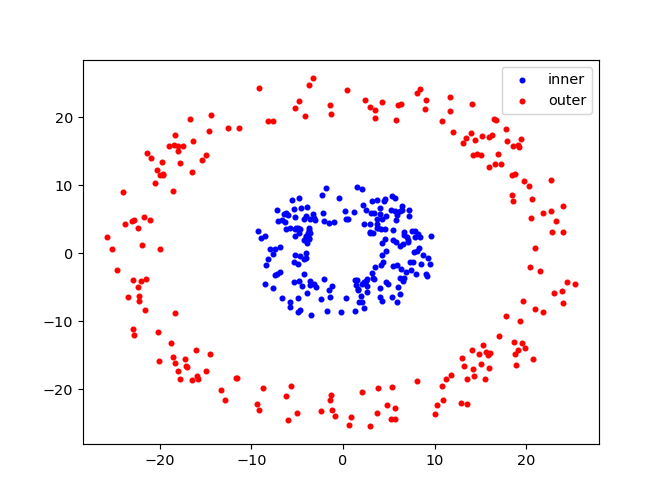

In [37]:
dims = 2
points = 200

inner_2d = zip(*gen_sphere(dims, points, 7, 3))
outer_2d = zip(*gen_sphere(dims, points, 23, 3))

plt.figure()

plt.scatter(inner_2d[0], inner_2d[1], c='blue', s=10, label='inner')
plt.scatter(outer_2d[0], outer_2d[1], c='red', s=10, label='outer')

plt.title("")
plt.legend()
plt.show()

## Zbiór w trzech wymiarach:

<IPython.core.display.Javascript object>


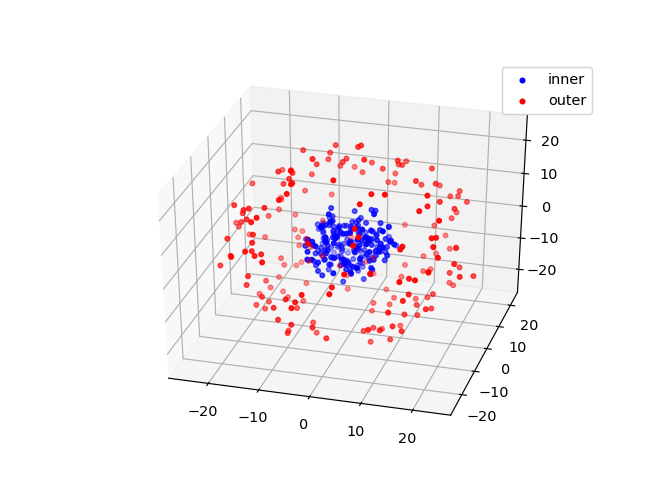

In [38]:
dims = 3
points = 200

inner_3d = zip(*gen_sphere(dims, points, 7, 3))
outer_3d = zip(*gen_sphere(dims, points, 23, 3))

plt.figure()
ax = plt.subplot(111, projection='3d')

ax.scatter(inner_3d[0], inner_3d[1], inner_3d[2], c='blue', s=10, label='inner')
ax.scatter(outer_3d[0], outer_3d[1], outer_3d[2], c='red', s=10, label='outer')

plt.title("")
plt.legend()
plt.show()

# Porównanie działania dla przestrzeni 10-wymiarowej

In [39]:
points = 200
dims = 10

inner = gen_sphere(dims, points, 20, 3)
outer = gen_sphere(dims, points, 40, 3)
data = inner + outer
data_clusters = np.array([0 for i in range(points)] + [1 for i in range(points)])

## PCA (Principal component analysis)

<IPython.core.display.Javascript object>


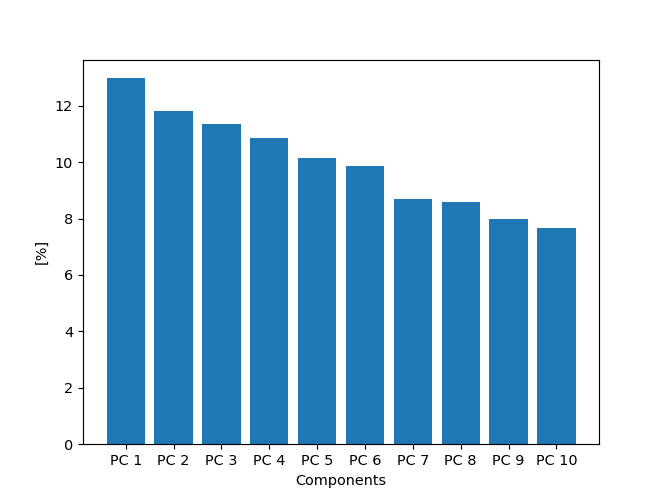

In [40]:
# PCA
embedding_pca = PCA(n_components = dims)
pca_x = embedding_pca.fit_transform(data)
#pca_x.shape

# histogram
display_hist(embedding_pca.explained_variance_, dims, True)

<IPython.core.display.Javascript object>


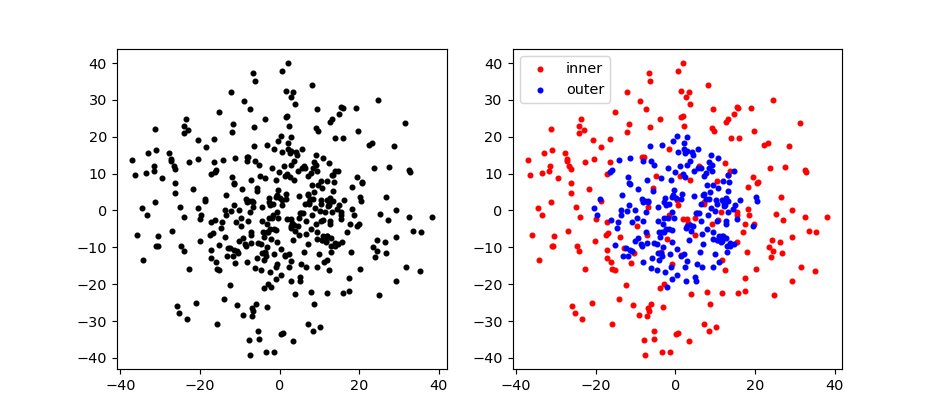

In [20]:
# wykres 2D
display_scatter_plot_2d(pca_x, data_clusters,'inner','outer','all')

## MDS (Multi-dimensional Scaling)

In [41]:
# MDS
embedding_mds = MDS() #TODO zabawa parametrami
mds_x = embedding_mds.fit_transform(data)
mds_x.shape

(400, 2)

<IPython.core.display.Javascript object>


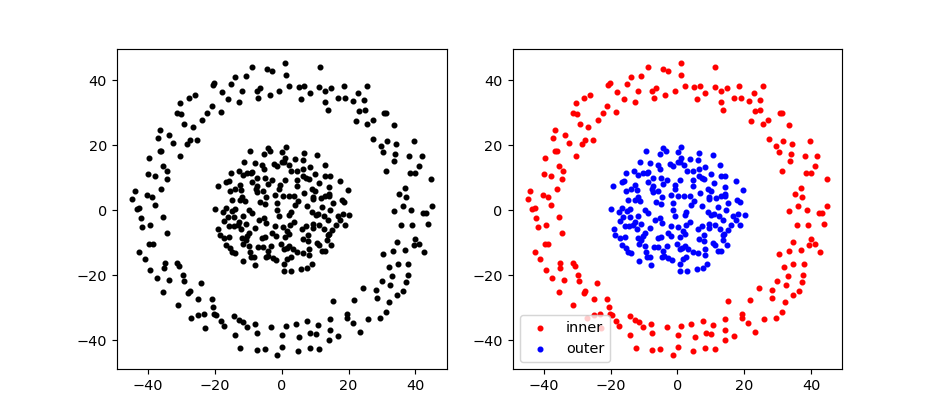

In [42]:
# wykres 2D
display_scatter_plot_2d(mds_x, data_clusters,'inner','outer','all')

#### Przydatne linki:
- https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html
- https://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling

## LLE (Locally Linear Embedding)

In [43]:
# LLE
embedding_lle = LocallyLinearEmbedding() #TODO zabawa parametrami
lle_x = embedding_lle.fit_transform(data)
lle_x.shape

(400, 2)

<IPython.core.display.Javascript object>


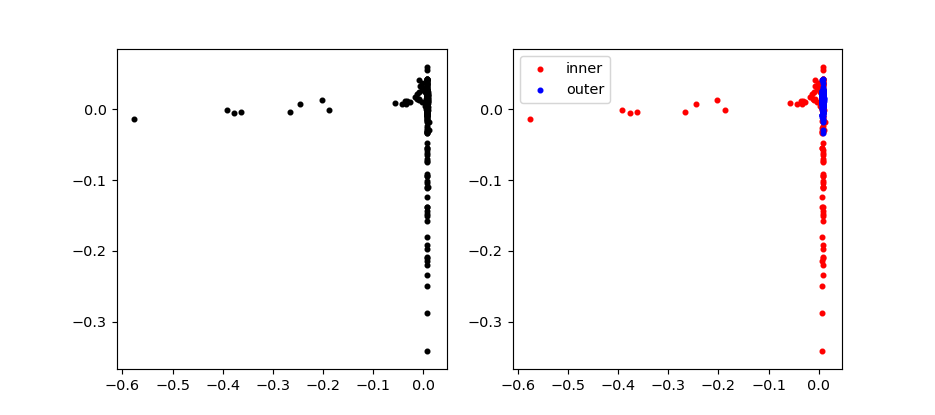

In [44]:
# wykres 2D
display_scatter_plot_2d(lle_x, data_clusters,'inner','outer','all')

#### Przydatne linki:
- https://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html#sklearn.manifold.LocallyLinearEmbedding
- https://scikit-learn.org/stable/modules/manifold.html#locally-linear-embedding

## Isomap

In [45]:
# LLE
embedding_isomap = Isomap() #TODO zabawa parametrami
isomap_x = embedding_isomap.fit_transform(data)
isomap_x.shape

(400, 2)

<IPython.core.display.Javascript object>


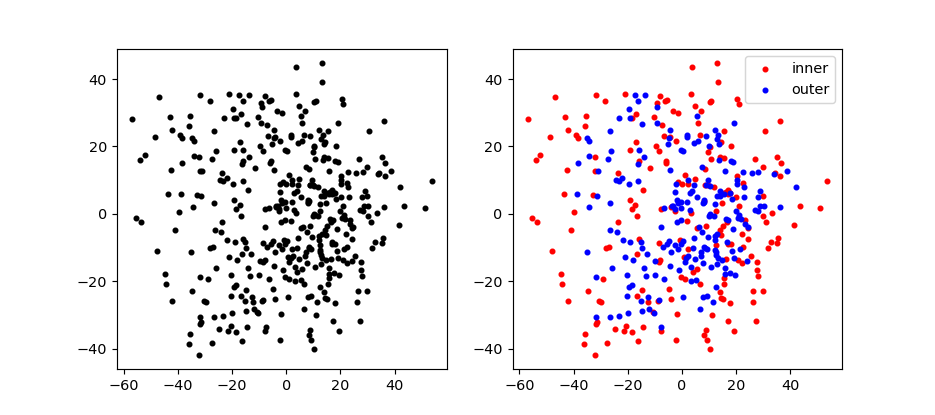

In [46]:
# wykres 2D
display_scatter_plot_2d(isomap_x, data_clusters,'inner','outer','all')

#### Przydatne linki:
- https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html#sklearn.manifold.Isomap
- https://scikit-learn.org/stable/modules/manifold.html#isomap

# 2. Metryka

# 3. Diagram Sheparda - diagram odległości

## Idealny przypadek (dla wejściowego zbioru 2d)

<IPython.core.display.Javascript object>


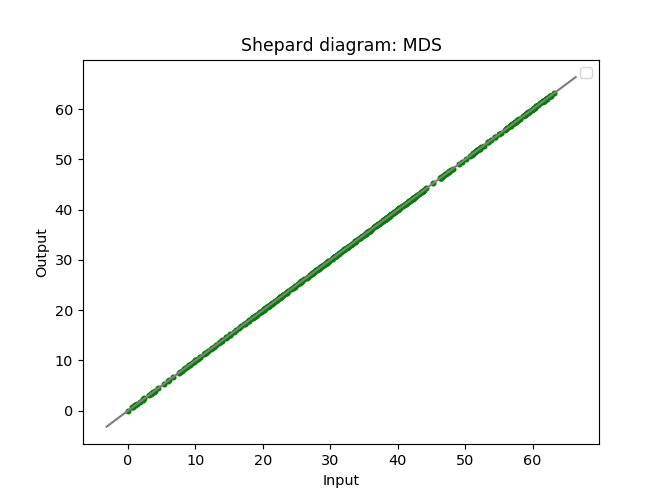

In [47]:
data_2d = gen_sphere(2, points, 20, 3) + gen_sphere(2, points, 40, 3)
mds_x_2d = embedding_mds.fit_transform(data_2d)

display_shepard_diagram(data_2d, mds_x_2d, 'MDS')

## MDS

<IPython.core.display.Javascript object>


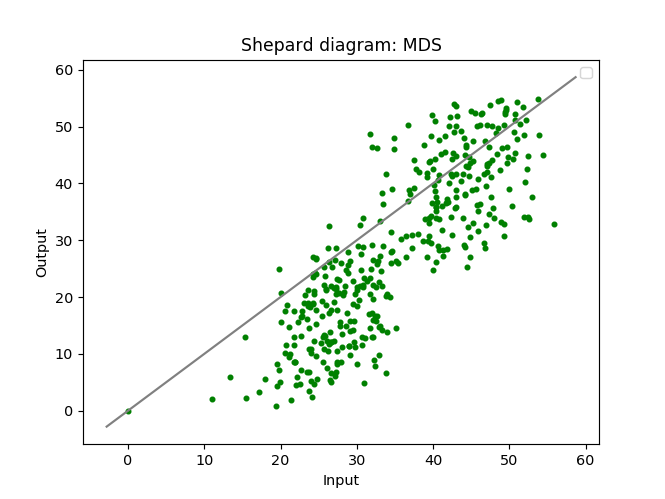

In [48]:
display_shepard_diagram(data, mds_x, 'MDS')

## LLE

<IPython.core.display.Javascript object>


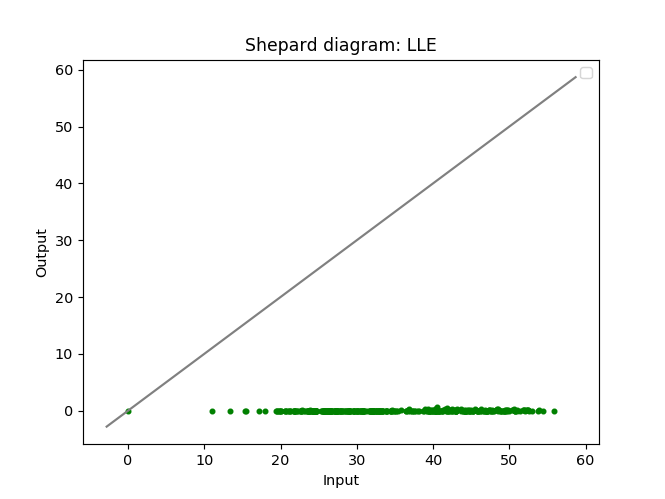

In [49]:
display_shepard_diagram(data, lle_x, 'LLE')

## Isomap

<IPython.core.display.Javascript object>


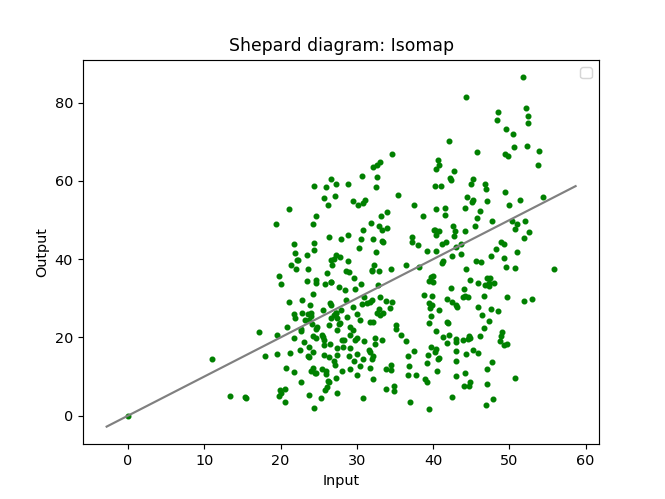

In [50]:
display_shepard_diagram(data, isomap_x, 'Isomap')

# Zadania
- Metody MDS, LLE oraz Isomap przyjmują różne parametry. Dotychczas zaprezentowano ich wersje domyślne. W ramach zadania należy zbadać wyniki MDS, LLE oraz Isomap dla zmienionych parametrów. 
- Porównanie wartości metryk nearest neighbours (NN) oraz k-nearest neighbours (kNN) dla różnych metod na zbiorze smallNORB. Uzupełnić tabelę (zapis NN-1 oznacza NN dla k=1):

| Metoda/Metryka | NN-1 | NN-10 | kNN-1 | kNN-3
| --- | --- | --- | --- | --- |
| PCA | ? | ? | ? | ? |
| MDS | ? | ? | ? | ? |
| LLE | ? | ? | ? | ? |
| Isomap | ? | ? | ? | ? |

- ???